## Import Packages

In [1]:
!pip install causalml

In [11]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
from xgboost import XGBRegressor
import warnings

from causalml.inference.meta import LRSRegressor
from causalml.inference.meta import XGBTRegressor, MLPTRegressor
from causalml.inference.meta import BaseXRegressor, BaseRRegressor, BaseSRegressor, BaseTRegressor
from causalml.match import NearestNeighborMatch, MatchOptimizer, create_table_one
from causalml.propensity import ElasticNetPropensityModel
from causalml.dataset import *
from causalml.metrics import *

warnings.filterwarnings('ignore')
plt.style.use('fivethirtyeight')

%matplotlib inline

Introduction
CausalML is a Python package that provides a suite of uplift modeling and causal inference methods using machine learning algorithms based on recent research. It provides a standard interface that allows user to estimate the Conditional Average Treatment Effect (CATE) or Individual Treatment Effect (ITE) from experimental or observational data. Essentially, it estimates the causal impact of intervention T on outcome Y for users with observed features X, without strong assumptions on the model form. The package currently supports the following methods:

- Tree-based algorithms
-- Uplift tree/random forests on KL divergence, Euclidean Distance, and Chi-Square
-- Uplift tree/random forests on Contextual Treatment Selection
- Meta-learner algorithms
-- S-learner
-- T-learner
-- X-learner
-- R-learner
In this notebook, we will generate some synthetic data to demonstrate how to use the various Meta-Learner algorithms in order to estimate Individual Treatment Effects (and Average Treatment Effects with confidence intervals).

## Generate synthetic data

We have implemented 4 modes of generating synthetic data (specified by input parameter mode). Refer to the References section for more detail on these data generation processes.

In [4]:
# Generate synthetic data using mode 1
y, X, treatment, tau, b, e = synthetic_data(mode=1, n=10000, p=8, sigma=1.0)

## Calculate Average Treatment Effect (ATE)

A meta-learner can be instantiated by calling a base learner class and providing an sklearn/xgboost regressor class as input. Alternatively, we have provided some ready-to-use learners that have already inherited their respective base learner class capabilities. This is more abstracted and allows these tools to be quickly and readily usable.

In [6]:
# Ready-to-use S-Learner using LinearRegression
learner_s = LRSRegressor()
ate_s = learner_s.estimate_ate(X=X, treatment=treatment, y=y)
print(ate_s)
print('ATE estimate: {:.03f}'.format(ate_s[0][0]))
print('ATE lower bound: {:.03f}'.format(ate_s[1][0]))
print('ATE upper bound: {:.03f}'.format(ate_s[2][0]))

(array([0.68830071]), array([0.63996619]), array([0.73663523]))
ATE estimate: 0.688
ATE lower bound: 0.640
ATE upper bound: 0.737


In [12]:
# Ready-to-use T-Learner using XGB
learner_t = XGBTRegressor()
ate_t = learner_t.estimate_ate(X=X, treatment=treatment, y=y)
print('Using the ready-to-use XGBTRegressor class')
print(ate_t)

# Calling the Base Learner class and feeding in XGB
learner_t = BaseTRegressor(learner=XGBRegressor())
ate_t = learner_t.estimate_ate(X=X, treatment=treatment, y=y)
print('\nUsing the BaseTRegressor class and using XGB (same result):')
print(ate_t)

# Calling the Base Learner class and feeding in LinearRegression
learner_t = BaseTRegressor(learner=LinearRegression())
ate_t = learner_t.estimate_ate(X=X, treatment=treatment, y=y)
print('\nUsing the BaseTRegressor class and using Linear Regression (different result):')
print(ate_t)

[09:48:40] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:48:41] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Using the ready-to-use XGBTRegressor class
(array([0.58260551]), array([0.54485501]), array([0.62035601]))
[09:48:41] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:48:41] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.

Using the BaseTRegressor class and using XGB (same result):
(array([0.58260551]), array([0.54485501]), array([0.62035601]))

Using the BaseTRegressor class and using Linear Regression (different result):
(array([0.67278977]), array([0.63205731]), array([0.71352223]))


In [13]:
# X Learner with propensity score input
# Calling the Base Learner class and feeding in XGB
learner_x = BaseXRegressor(learner=XGBRegressor())
ate_x = learner_x.estimate_ate(X=X, treatment=treatment, y=y, p=e)
print('Using the BaseXRegressor class and using XGB:')
print(ate_x)

# Calling the Base Learner class and feeding in LinearRegression
learner_x = BaseXRegressor(learner=LinearRegression())
ate_x = learner_x.estimate_ate(X=X, treatment=treatment, y=y, p=e)
print('\nUsing the BaseXRegressor class and using Linear Regression:')
print(ate_x)

[09:49:08] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:49:09] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:49:09] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:49:09] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Using the BaseXRegressor class and using XGB:
(array([0.51398802]), array([0.47653355]), array([0.55144249]))

Using the BaseXRegressor class and using Linear Regression:
(array([0.67278977]), array([0.63205731]), array([0.71352223]))


In [14]:
# X Learner without propensity score input
# Calling the Base Learner class and feeding in XGB
learner_x = BaseXRegressor(XGBRegressor())
ate_x = learner_x.estimate_ate(X=X, treatment=treatment, y=y)
print('Using the BaseXRegressor class and using XGB without propensity score input:')
print(ate_x)

# Calling the Base Learner class and feeding in LinearRegression
learner_x = BaseXRegressor(learner=LinearRegression())
ate_x = learner_x.estimate_ate(X=X, treatment=treatment, y=y)
print('\nUsing the BaseXRegressor class and using Linear Regression without propensity score input:')
print(ate_x)

[09:49:21] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:49:21] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:49:22] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:49:22] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Using the BaseXRegressor class and using XGB without propensity score input:
(array([0.51780427]), array([0.48034957]), array([0.55525896]))

Using the BaseXRegressor class and using Linear Regression without propensity score input:
(array([0.67278977]), array([0.63205731]), array([0.71352223]))


In [15]:
# R Learner with propensity score input
# Calling the Base Learner class and feeding in XGB
learner_r = BaseRRegressor(learner=XGBRegressor())
ate_r = learner_r.estimate_ate(X=X, treatment=treatment, y=y, p=e)
print('Using the BaseRRegressor class and using XGB:')
print(ate_r)

# Calling the Base Learner class and feeding in LinearRegression
learner_r = BaseRRegressor(learner=LinearRegression())
ate_r = learner_r.estimate_ate(X=X, treatment=treatment, y=y, p=e)
print('Using the BaseRRegressor class and using Linear Regression:')
print(ate_r)

[09:50:19] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Using the BaseRRegressor class and using XGB:
(array([0.50594559]), array([0.50554012]), array([0.50635105]))
Using the BaseRRegressor class and using Linear Regression:
(array([0.4984442]), array([0.49803007]), array([0.49885832]))


In [16]:
# R Learner without propensity score input
# Calling the Base Learner class and feeding in XGB
learner_r = BaseRRegressor(learner=XGBRegressor())
ate_r = learner_r.estimate_ate(X=X, treatment=treatment, y=y)
print('Using the BaseRRegressor class and using XGB without propensity score input:')
print(ate_r)

# Calling the Base Learner class and feeding in LinearRegression
learner_r = BaseRRegressor(learner=LinearRegression())
ate_r = learner_r.estimate_ate(X=X, treatment=treatment, y=y)
print('Using the BaseRRegressor class and using Linear Regression without propensity score input:')
print(ate_r)

[09:50:28] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Using the BaseRRegressor class and using XGB without propensity score input:
(array([0.48532142]), array([0.48491614]), array([0.4857267]))
Using the BaseRRegressor class and using Linear Regression without propensity score input:
(array([0.57485282]), array([0.57443872]), array([0.57526693]))


## Calculate Individual Treatment Effect (ITE/CATE)

In [2]:
# S Learner
learner_s = LRSRegressor()
cate_s = learner_s.fit_predict(X=X, treatment=treatment, y=y)

# T Learner
learner_t = BaseTRegressor(learner=XGBRegressor())
cate_t = learner_t.fit_predict(X=X, treatment=treatment, y=y)

# X Learner with propensity score input
learner_x = BaseXRegressor(learner=XGBRegressor())
cate_x = learner_x.fit_predict(X=X, treatment=treatment, y=y, p=e)

# X Learner without propensity score input
learner_x_no_p = BaseXRegressor(learner=XGBRegressor())
cate_x_no_p = learner_x_no_p.fit_predict(X=X, treatment=treatment, y=y)

# R Learner with propensity score input 
learner_r = BaseRRegressor(learner=XGBRegressor())
cate_r = learner_r.fit_predict(X=X, treatment=treatment, y=y, p=e)

# R Learner without propensity score input
learner_r_no_p = BaseRRegressor(learner=XGBRegressor())
cate_r_no_p = learner_r_no_p.fit_predict(X=X, treatment=treatment, y=y)

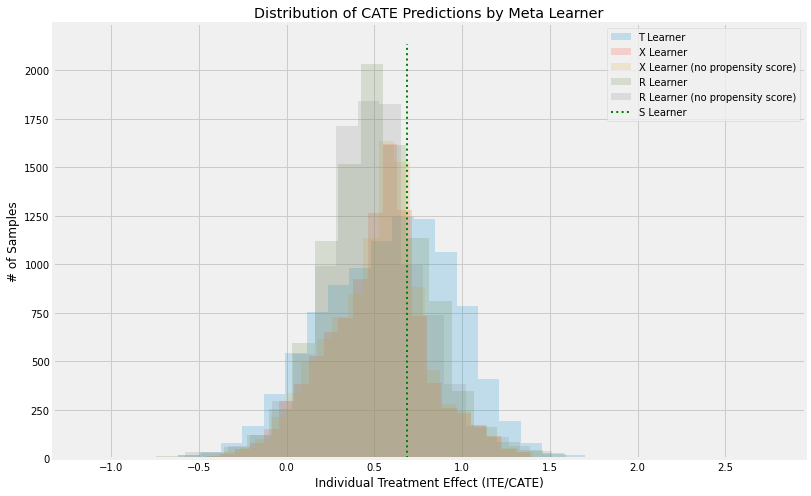

In [18]:
alpha=0.2
bins=30
plt.figure(figsize=(12,8))
plt.hist(cate_t, alpha=alpha, bins=bins, label='T Learner')
plt.hist(cate_x, alpha=alpha, bins=bins, label='X Learner')
plt.hist(cate_x_no_p, alpha=alpha, bins=bins, label='X Learner (no propensity score)')
plt.hist(cate_r, alpha=alpha, bins=bins, label='R Learner')
plt.hist(cate_r_no_p, alpha=alpha, bins=bins, label='R Learner (no propensity score)')
plt.vlines(cate_s[0], 0, plt.axes().get_ylim()[1], label='S Learner',
           linestyles='dotted', colors='green', linewidth=2)
plt.title('Distribution of CATE Predictions by Meta Learner')
plt.xlabel('Individual Treatment Effect (ITE/CATE)')
plt.ylabel('# of Samples')
_=plt.legend()

## Validating Meta-Learner Accuracy

In [3]:
train_summary, validation_summary = get_synthetic_summary_holdout(simulate_nuisance_and_easy_treatment,
                                                                  n=10000,
                                                                  valid_size=0.2,
                                                                  k=10)

In [21]:
train_summary

,Abs % Error of ATE,MSE,KL Divergence
Actuals,0.000000,0.000000,0.000000
S Learner (LR),0.399080,0.082658,3.762274
S Learner (XGB),0.165274,0.026938,0.178394
T Learner (LR),0.382019,0.042476,0.355759
T Learner (XGB),0.179488,0.079577,0.339975
X Learner (LR),0.382019,0.042476,0.355759
X Learner (XGB),0.085923,0.034579,0.108190
R Learner (LR),0.323611,0.041185,0.328126
R Learner (XGB),0.061322,0.057889,0.080276


In [22]:
validation_summary

,Abs % Error of ATE,MSE,KL Divergence
Actuals,0.000000,0.000000,0.000000
S Learner (LR),0.395813,0.082098,3.767526
S Learner (XGB),0.163898,0.026807,0.206282
T Learner (LR),0.380550,0.042412,0.386487
T Learner (XGB),0.174395,0.074708,0.347050
X Learner (LR),0.380550,0.042412,0.386487
X Learner (XGB),0.083119,0.031688,0.134812
R Learner (LR),0.323777,0.041352,0.366786
R Learner (XGB),0.066223,0.054304,0.099595


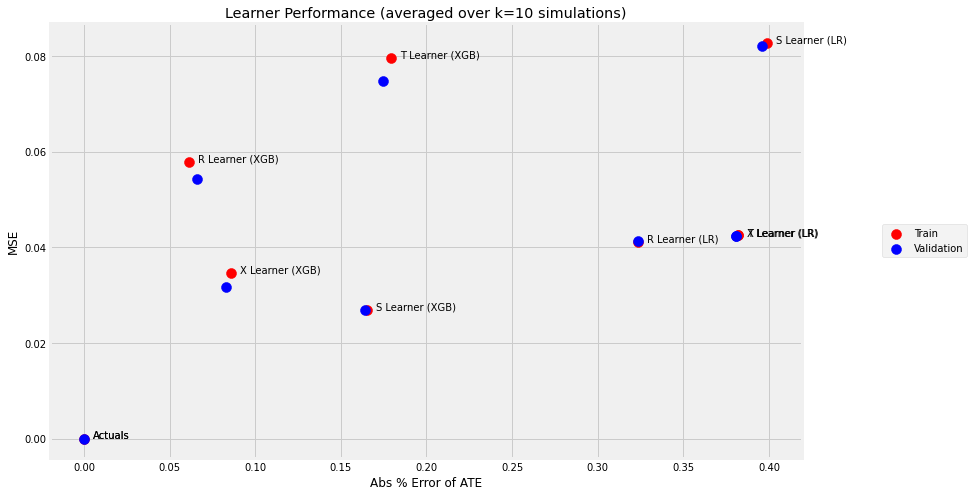

In [23]:
scatter_plot_summary_holdout(train_summary,
                             validation_summary,
                             k=10,
                             label=['Train', 'Validation'],
                             drop_learners=[],
                             drop_cols=[])


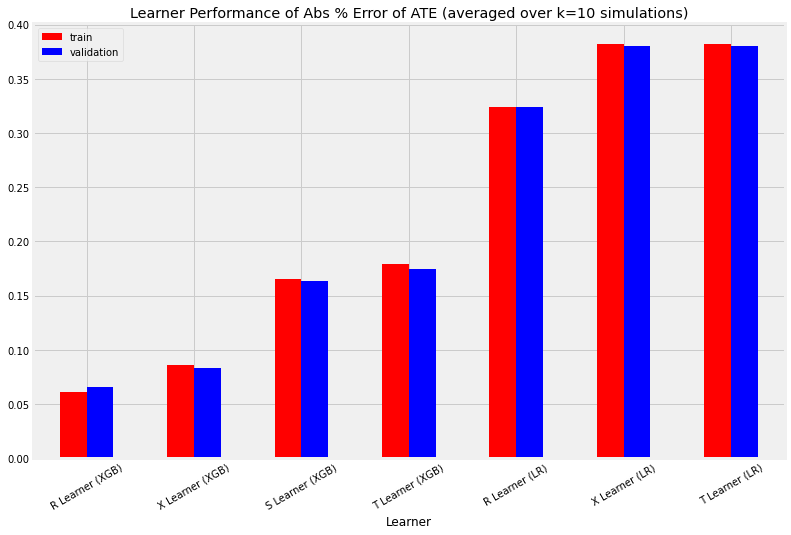

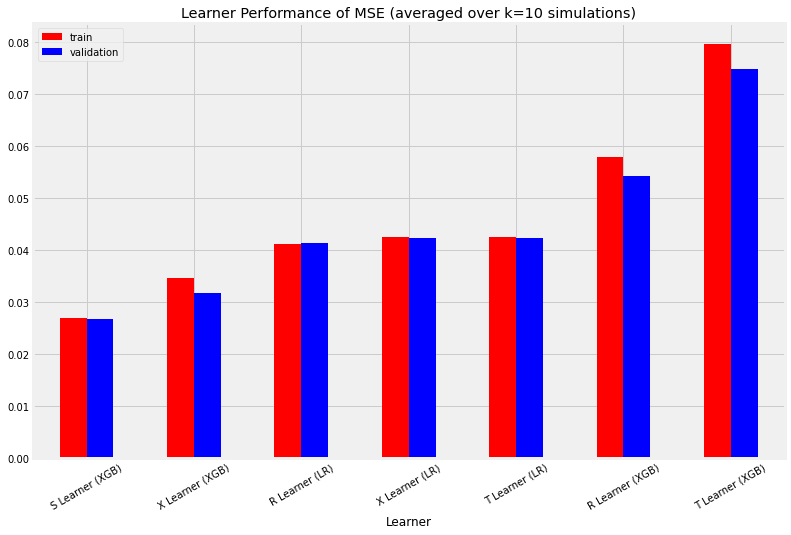

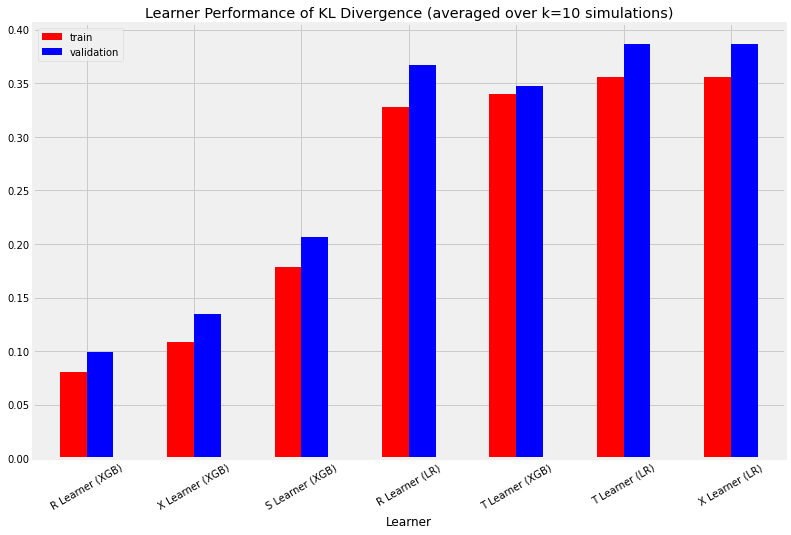

In [24]:
bar_plot_summary_holdout(train_summary,
                         validation_summary,
                         k=10,
                         drop_learners=['S Learner (LR)'],
                         drop_cols=[])

In [4]:
# Single simulation
train_preds, valid_preds = get_synthetic_preds_holdout(simulate_nuisance_and_easy_treatment,
                                                       n=50000,
                                                       valid_size=0.2)

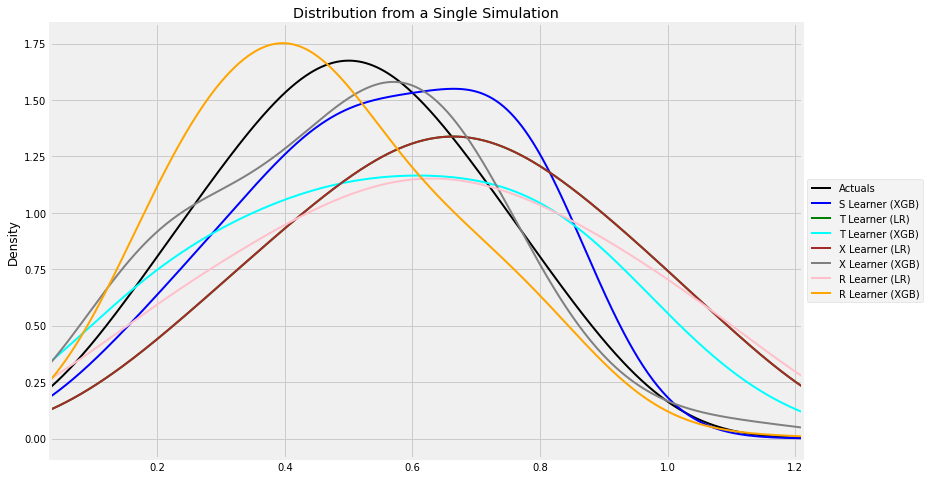

In [26]:
#distribution plot for signle simulation of Training
distr_plot_single_sim(train_preds, kind='kde', linewidth=2, bw_method=0.5,
                      drop_learners=['S Learner (LR)',' S Learner (XGB)'])

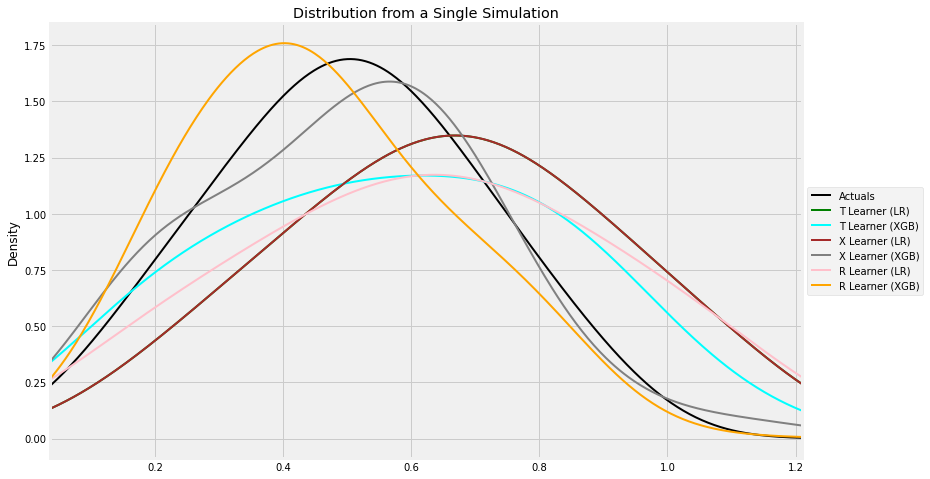

In [27]:
#distribution plot for signle simulation of Validaiton
distr_plot_single_sim(valid_preds, kind='kde', linewidth=2, bw_method=0.5,
                      drop_learners=['S Learner (LR)', 'S Learner (XGB)'])

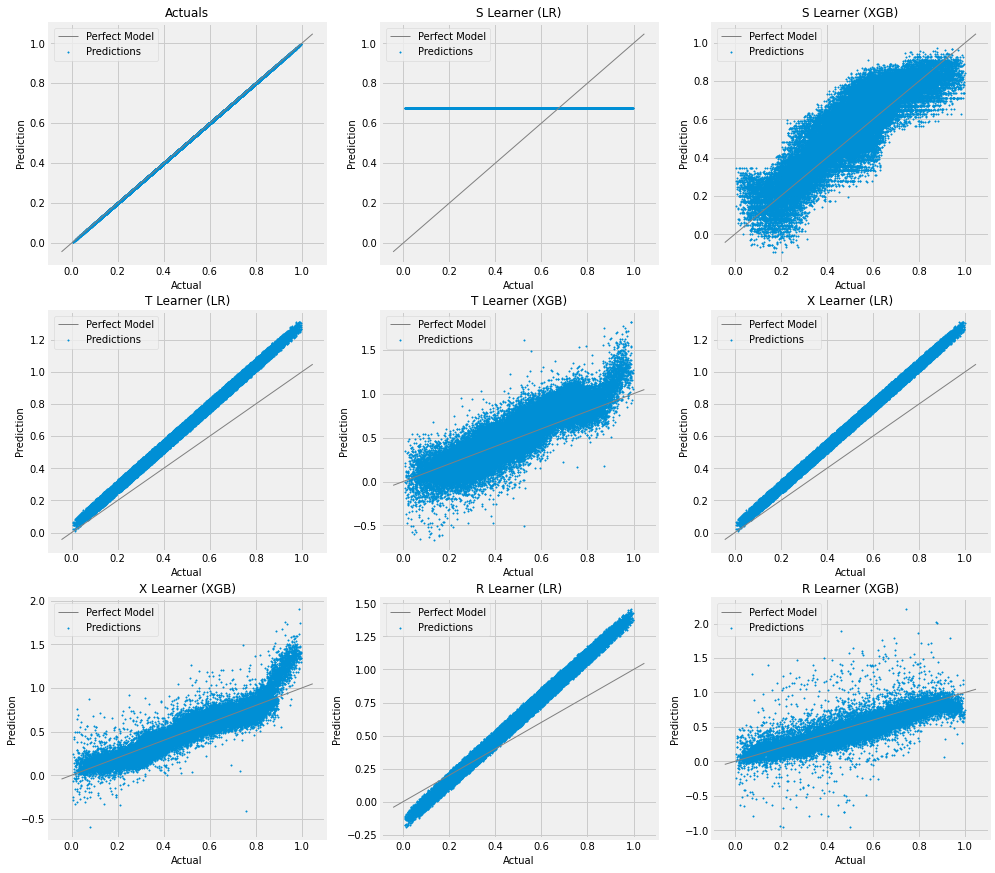

In [28]:
# Scatter Plots for a Single Simulation of Training Data
scatter_plot_single_sim(train_preds)

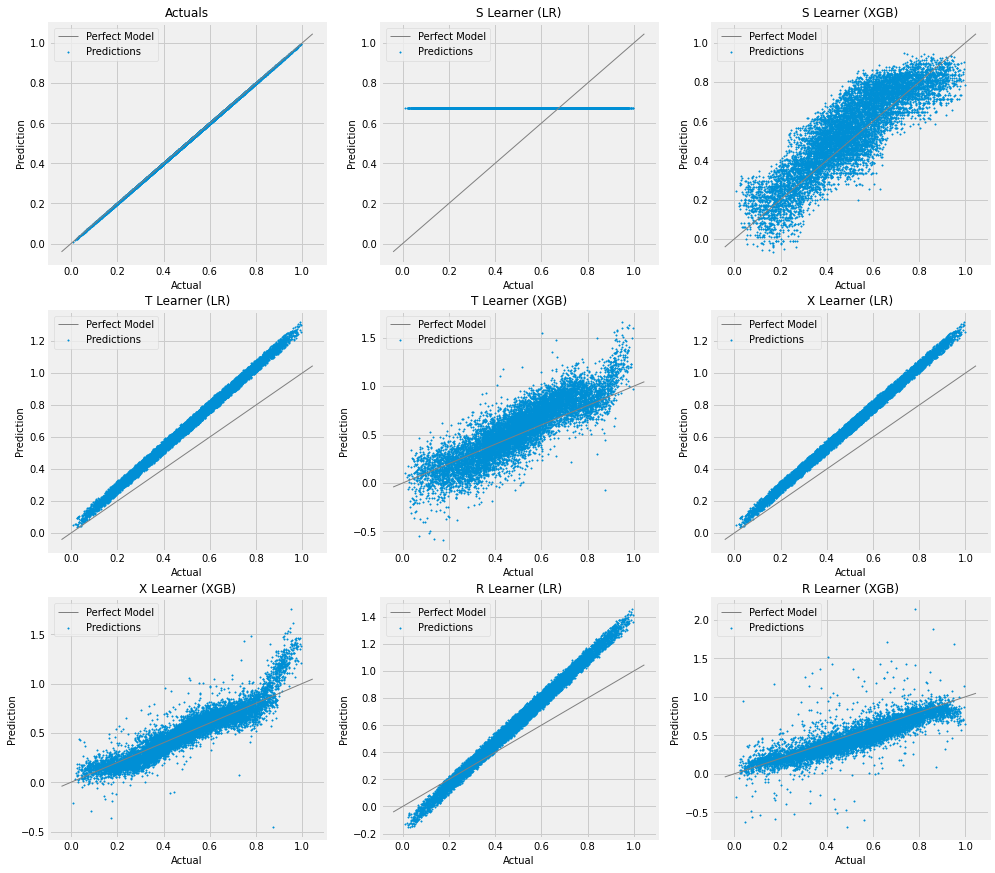

In [29]:
# Scatter Plots for a Single Simulation of Validaiton Data
scatter_plot_single_sim(valid_preds)

,Learner,cum_gain_auuc
0,Actuals,4.935069e+06
2,T Learner (LR),4.932407e+06
4,X Learner (LR),4.932407e+06
6,R Learner (LR),4.930752e+06
5,X Learner (XGB),4.878659e+06
7,R Learner (XGB),4.844302e+06
3,T Learner (XGB),4.830517e+06
1,S Learner (XGB),4.827102e+06
8,Random,4.002594e+06


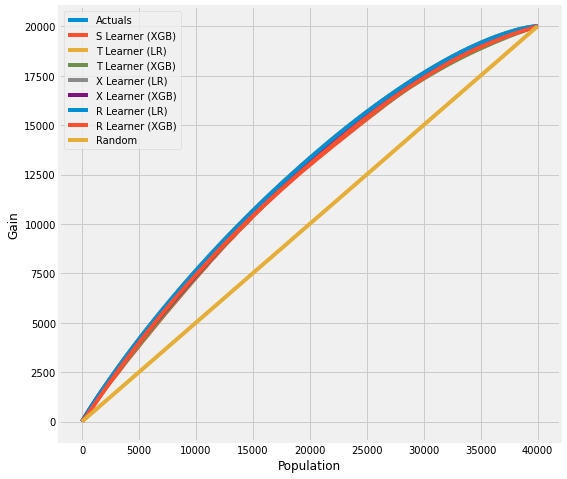

In [30]:
# Cumulative Gain AUUC values for a Single Simulation of Training Data
get_synthetic_auuc(train_preds, drop_learners=['S Learner (LR)'])

,Learner,cum_gain_auuc
0,Actuals,309441.774543
2,T Learner (LR),309274.086964
4,X Learner (LR),309274.086964
6,R Learner (LR),309169.804237
5,X Learner (XGB),305935.080224
7,R Learner (XGB),303867.091555
3,T Learner (XGB),302748.477820
1,S Learner (XGB),302557.073293
8,Random,251100.714804


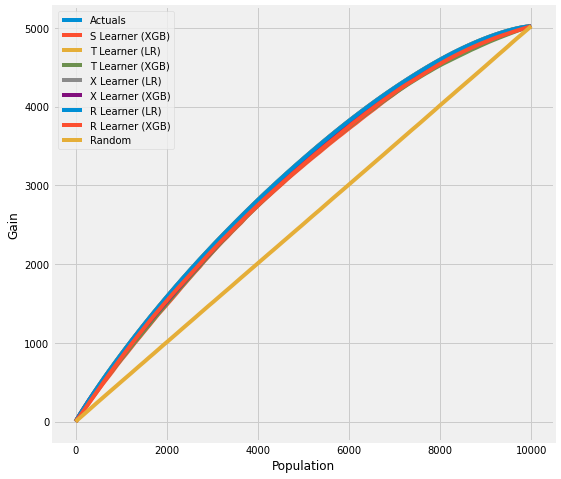

In [31]:
# Cumulative Gain AUUC values for a Single Simulation of Validaiton Data
get_synthetic_auuc(valid_preds, drop_learners=['S Learner (LR)'])

## Interpretable Causal ML

In [39]:
from lightgbm import LGBMRegressor
import time

In [32]:
plt.style.use('fivethirtyeight')

In [35]:
n_features = 25
n_samples = 10000
y, X, w, tau, b, e = synthetic_data(mode=1, n=n_samples, p=n_features, sigma=0.5)

w_multi = np.array(['treatment_A' if x==1 else 'control' for x in w])
e_multi = {'treatment_A': e}

feature_names = ['stars', 'tiger', 'merciful', 'quixotic', 'fireman', 'dependent',
                 'shelf', 'touch', 'barbarous', 'clammy', 'playground', 'rain', 'offer',
                 'cute', 'future', 'damp', 'nonchalant', 'change', 'rigid', 'sweltering',
                 'eight', 'wrap', 'lethal', 'adhesive', 'lip']  # specify feature names

model_tau = LGBMRegressor(importance_type='gain')  # specify model for model_tau

## S Learner

In [36]:
base_algo = LGBMRegressor()
# base_algo = XGBRegressor()
# base_algo = RandomForestRegressor()
# base_algo = LinearRegression()

slearner = BaseSRegressor(base_algo, control_name='control')
slearner.estimate_ate(X, w_multi, y)

array([0.56644414])

In [37]:
slearner_tau = slearner.fit_predict(X, w_multi, y)

## Feature Importance (method = auto)

In [40]:
start_time = time.time()

slearner.get_importance(X=X, 
                        tau=slearner_tau, 
                        method='permutation', 
                        features=feature_names, 
                        random_state=42)

print("Elapsed time: %s seconds" % (time.time() - start_time))

Elapsed time: 3.852780818939209 seconds


### Shapley Values

In [42]:
shap_slearner = slearner.get_shap_values(X=X, tau=slearner_tau)
shap_slearner

{'treatment_A': array([[ 1.00643497e-01,  2.18954933e-01,  1.02564175e-02, ...,
          2.97927756e-03,  3.16205370e-04,  1.63377217e-03],
        [ 3.99968204e-02,  2.00608575e-01, -1.46035420e-02, ...,
          1.63268467e-04, -1.49056582e-03,  3.30705773e-04],
        [-1.23591697e-01,  3.26154308e-02, -6.09919916e-02, ...,
         -1.15284721e-03,  3.33782965e-03, -9.05529264e-05],
        ...,
        [ 4.82866195e-02, -2.25026628e-01,  8.44538861e-03, ...,
          9.07025145e-05, -3.47537818e-03,  1.85970639e-04],
        [ 1.87596832e-01, -2.47044636e-01,  1.06394180e-02, ...,
          2.02409500e-04, -1.19650798e-03,  6.01728078e-05],
        [ 1.13212998e-01,  6.31470375e-02,  1.39370445e-02, ...,
         -4.33088002e-05, -3.44808458e-03,  3.15102216e-04]])}

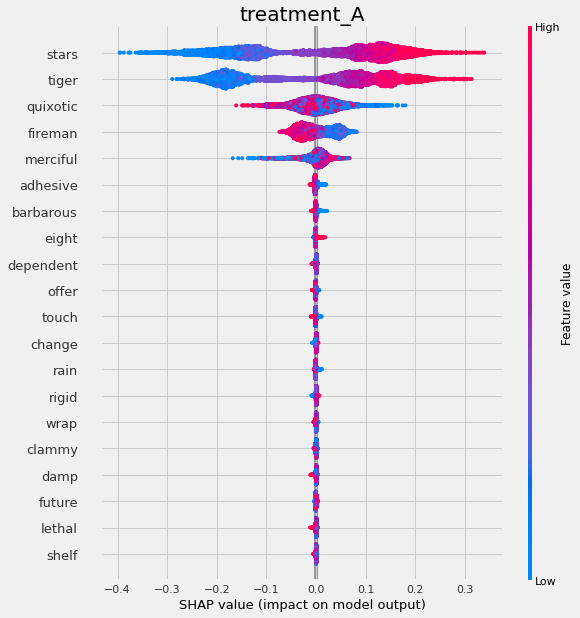

In [43]:
# Plot shap values without specifying shap_dict
slearner.plot_shap_values(X=X, tau=slearner_tau, features=feature_names)

## Uplift Tree Visualization

Supported Models
These visualization functions work only for tree-based algorithms:

- Uplift tree/random forests on KL divergence, Euclidean Distance, and Chi-Square
- Uplift tree/random forests on Contextual Treatment Selection

Currently, they are NOT supporting Meta-learner algorithms

- S-learner
- T-learner
- X-learner
- R-learner




Supported Usage
This notebook will show how to use visualization for:

- Uplift Tree and Uplift Random Forest

  - Visualize a trained uplift classification tree model
  - Visualize an uplift tree in a trained uplift random forests

- Training and Validation Data

  - Visualize the validation tree: fill the trained uplift classification tree with validation (or testing) data, and show the statistics for both training data and validation data

- One Treatment Group and Multiple Treatment Groups

  - Visualize the case where there are one control group and one treatment group
  - Visualize the case where there are one control group and multiple treatment groups

In [49]:
from causalml.dataset import make_uplift_classification
from causalml.inference.tree import UpliftTreeClassifier, UpliftRandomForestClassifier
from causalml.inference.tree import uplift_tree_string, uplift_tree_plot
from IPython.display import Image

## One Control + One Treatment for Uplift Classification Tree

In [45]:
# Data generation
df, x_names = make_uplift_classification()

# Rename features for easy interpretation of visualization
x_names_new = ['feature_%s'%(i) for i in range(len(x_names))]
rename_dict = {x_names[i]:x_names_new[i] for i in range(len(x_names))}
df = df.rename(columns=rename_dict)
x_names = x_names_new

df.head()

df = df[df['treatment_group_key'].isin(['control','treatment1'])]

# Look at the conversion rate and sample size in each group
df.pivot_table(values='conversion',
               index='treatment_group_key',
               aggfunc=[np.mean, np.size],
               margins=True)

,mean,size
,conversion,conversion
treatment_group_key,,
control,0.5110,1000
treatment1,0.5140,1000
All,0.5125,2000


In [46]:
# Split data to training and testing samples for model validation (next section)
df_train, df_test = train_test_split(df, test_size=0.2, random_state=111)

# Train uplift tree
uplift_model = UpliftTreeClassifier(max_depth = 4, min_samples_leaf = 200, min_samples_treatment = 50, n_reg = 100, evaluationFunction='KL', control_name='control')

uplift_model.fit(df_train[x_names].values,
                 treatment=df_train['treatment_group_key'].values,
                 y=df_train['conversion'].values)

In [47]:
# Print uplift tree as a string
result = uplift_tree_string(uplift_model.fitted_uplift_tree, x_names)

feature_17 >= -0.44234212654232735?
yes -> feature_10 >= 1.020659213325515?
		yes -> {'treatment1': 0.606557, 'control': 0.381356}
		no  -> {'treatment1': 0.526786, 'control': 0.507812}
no  -> feature_9 >= 0.8142773340486678?
		yes -> {'treatment1': 0.61, 'control': 0.459677}
		no  -> feature_4 >= 0.280545459525536?
				yes -> {'treatment1': 0.41433, 'control': 0.552288}
				no  -> {'treatment1': 0.574803, 'control': 0.507042}


Read the tree
- First line: node split condition
- impurity: the value for the loss function
- total_sample: total sample size in this node
- group_sample: sample size by treatment group
- uplift score: the treatment effect between treatment and control (when there are multiple treatment groups, this is the maximum of the treatment effects)
- uplift p_value: the p_value for the treatment effect
- validation uplift score: when validation data is filled in the tree, this reflects the uplift score based on the - validation data. It can be compared with the uplift score (for training data) to check if there are over-fitting issue.

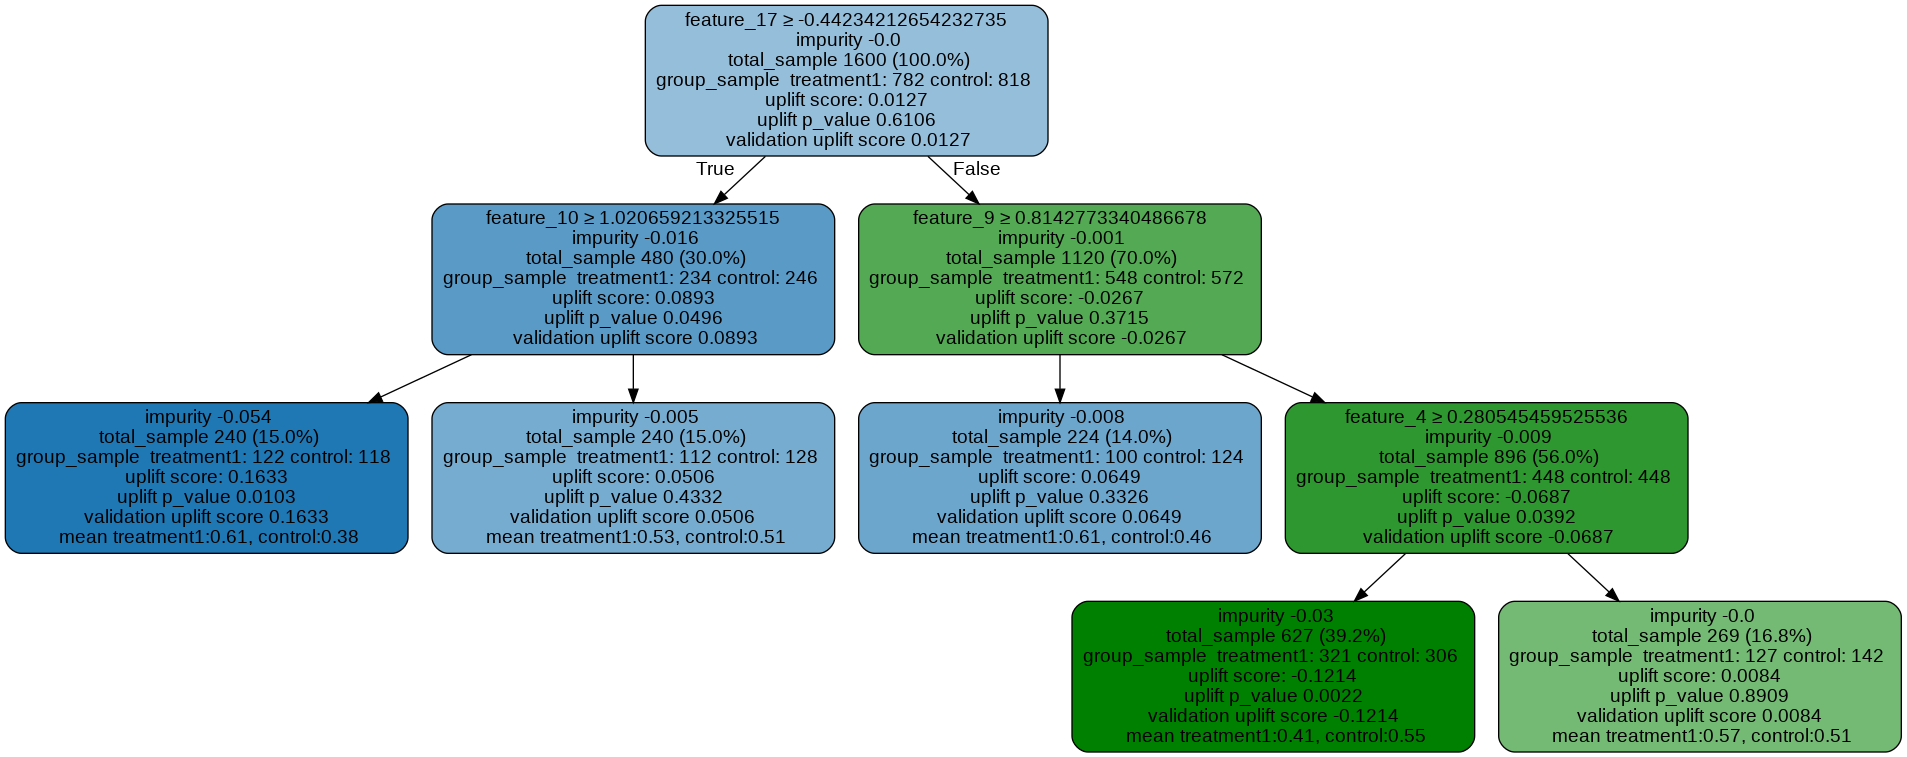

In [50]:
# Plot uplift tree
graph = uplift_tree_plot(uplift_model.fitted_uplift_tree,x_names)
Image(graph.create_png())

## Visualize Validation Tree: One Control + One Treatment for Uplift Classification Tree

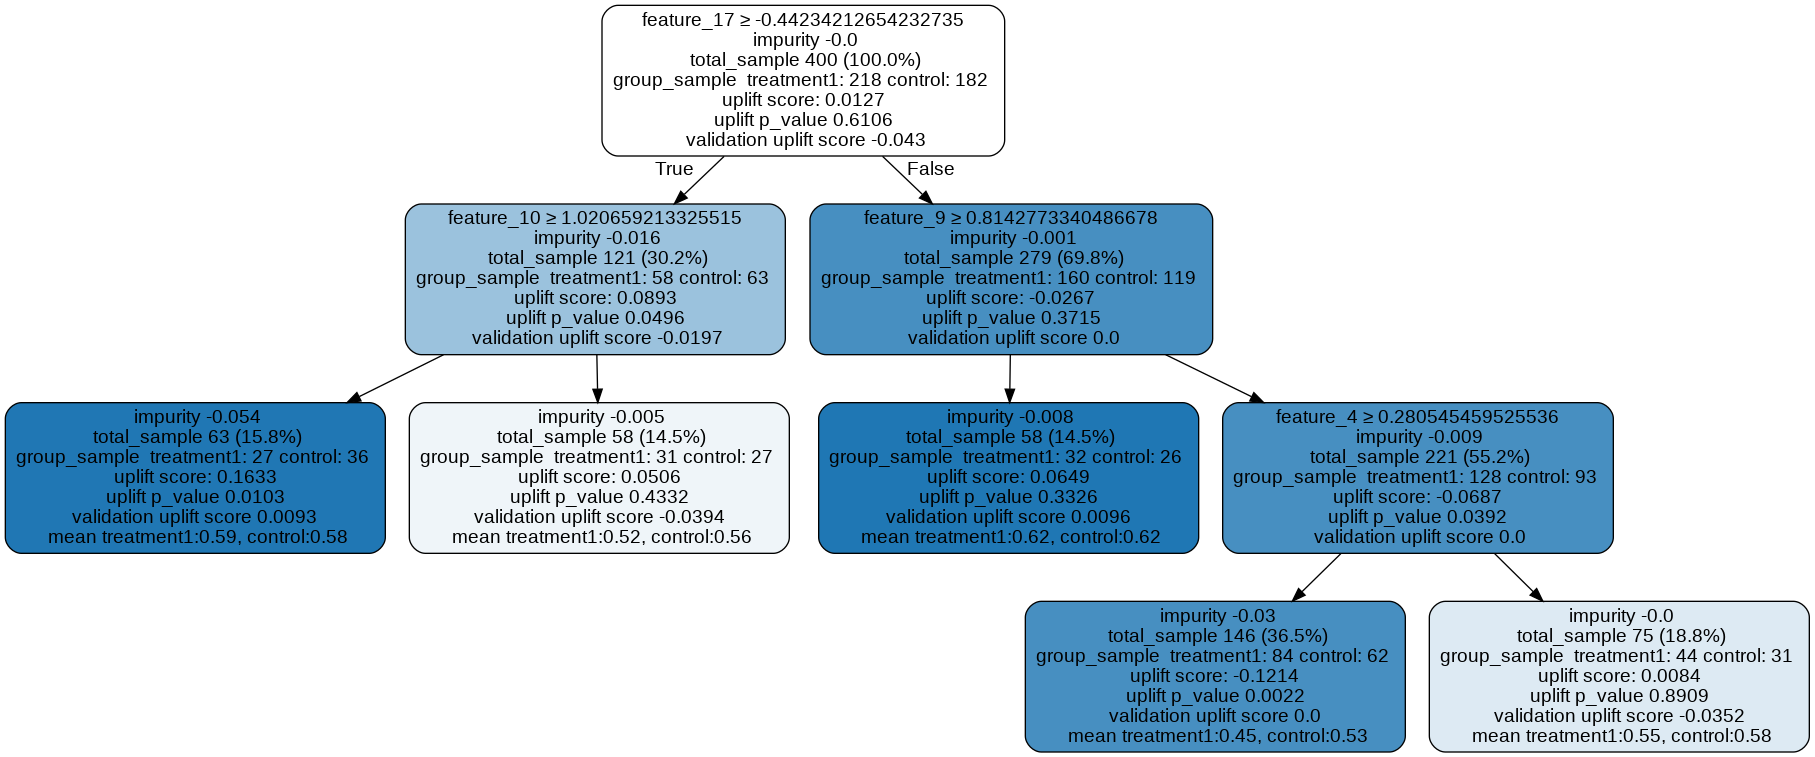

In [51]:
### Fill the trained tree with testing data set 
# The uplift score based on testing dataset is shown as validation uplift score in the tree nodes
uplift_model.fill(X=df_test[x_names].values, treatment=df_test['treatment_group_key'].values, y=df_test['conversion'].values)

# Plot uplift tree
graph = uplift_tree_plot(uplift_model.fitted_uplift_tree,x_names)
Image(graph.create_png())

## Visualize a Tree in Random Forest

In [53]:
# Split data to training and testing samples for model validation (next section)
df_train, df_test = train_test_split(df, test_size=0.2, random_state=111)

# Train uplift tree
uplift_model = UpliftRandomForestClassifier(n_estimators=5, max_depth = 5, min_samples_leaf = 200, min_samples_treatment = 50, n_reg = 100, evaluationFunction='KL', control_name='control')

uplift_model.fit(df_train[x_names].values,
                 treatment=df_train['treatment_group_key'].values,
                 y=df_train['conversion'].values)

In [54]:
# Specify a tree in the random forest (the index can be any integer from 0 to n_estimators-1)
uplift_tree = uplift_model.uplift_forest[0]
# Print uplift tree as a string
result = uplift_tree_string(uplift_tree.fitted_uplift_tree, x_names)

feature_9 >= 0.5262178962669349?
yes -> feature_1 >= 0.015045149699055904?
		yes -> {'treatment1': 0.355372, 'control': 0.344538}
		no  -> {'treatment1': 0.867188, 'control': 0.642857}
no  -> feature_17 >= -0.3932679774276595?
		yes -> {'treatment1': 0.549669, 'control': 0.449198}
		no  -> feature_9 >= -0.8241054633876749?
				yes -> feature_2 >= 0.09806971467164202?
						yes -> {'treatment1': 0.360902, 'control': 0.602837}
						no  -> {'treatment1': 0.438017, 'control': 0.496732}
				no  -> {'treatment1': 0.495327, 'control': 0.535433}


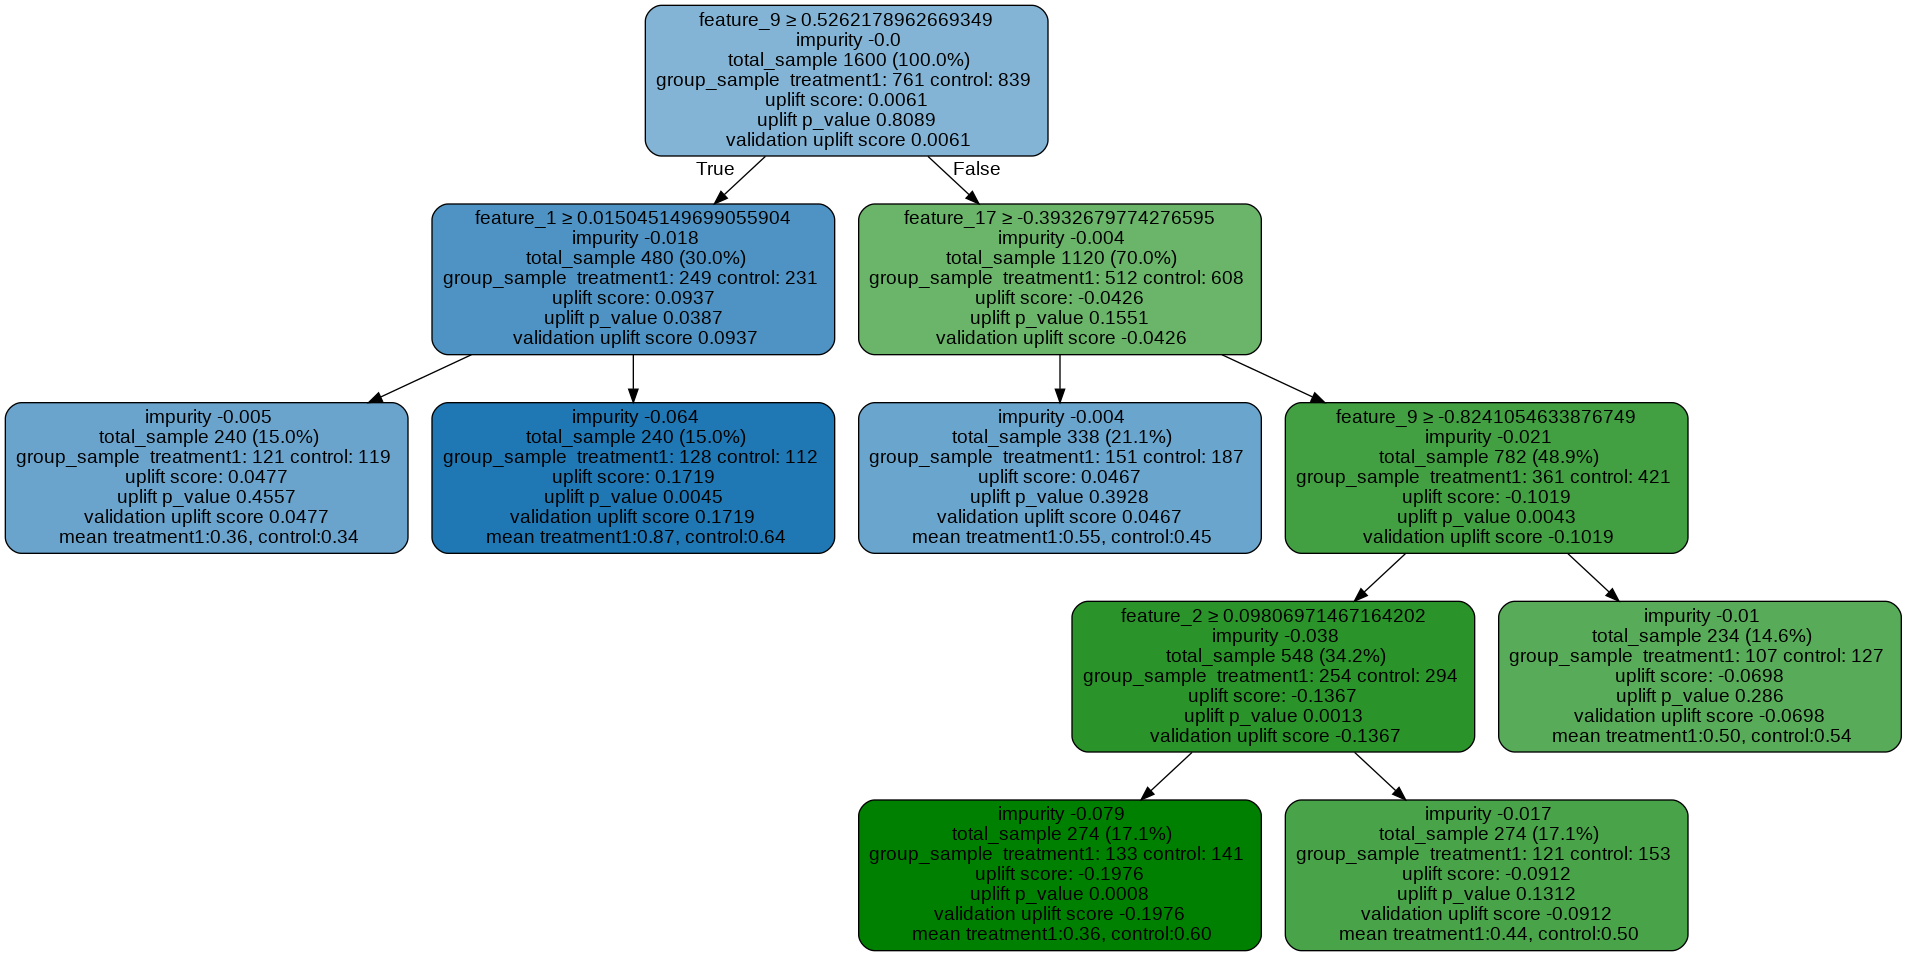

In [55]:
# Plot uplift tree
graph = uplift_tree_plot(uplift_tree.fitted_uplift_tree,x_names)
Image(graph.create_png())